## Directions
> Split the metadata from [Poore et al 2020](https://www.nature.com/articles/s41586-020-2095-1)'s samples and using a random half of the data to train any binary predictor with a continuous output score to predict whether or not the sample is an ovarian cancer. Give me an ROC curve with its associated AUC. Recommendation is to binarize / one-hot encode all the distinct string values of the metadata columns and train a logistic regression.  
>**Feature Columns**  
>  - `experimental_strategy`  
>  - `sample_type`  
>  - `tissue_source_site_label`  
>  - `platform`  
>  - `data_submitting_center_label`  
>  - `portion_is_ffpe`    
>
>**Target**  
>  - `disease_type == "Ovarian Serous Cystadenocarcinoma"`

## Setup

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import RocCurveDisplay, auc

import matplotlib.pyplot as plt

## Data

In [2]:
PROJ_ROOT = Path().resolve().parent

data_path = PROJ_ROOT / "data" / "poore-2020-metadata-subset.csv"

# not going to handle NaNs
df = pd.read_csv(data_path, index_col=0, na_values="Not available").dropna(
    ignore_index=True
)

y = df.disease_type == "Ovarian Serous Cystadenocarcinoma"

# not doing downstream analysis with this, might as well drop
df.drop("disease_type", axis=1, inplace=True)

In [3]:
# perc ovarian cancer obs
print(f"% Ovarian Serous Cystadenocarcinoma: {(y.sum() / len(df)) * 100:.2f}")

% Ovarian Serous Cystadenocarcinoma: 5.72


In [4]:
# binarize all categorical feature columns, convert to sparse matrix
X = pd.get_dummies(df, sparse=True).sparse.to_coo().tocsr()
# shapes match expectation
X.shape, y.shape

((18010, 220), (18010,))

## Logistic Regression

In [5]:
# make sure to stratify train/test split based on label.
# important considering large class imbalance (on 5% positive)
nsplits = 6
cv = StratifiedKFold(nsplits)
classifier = LogisticRegression(solver="lbfgs", max_iter=1000)

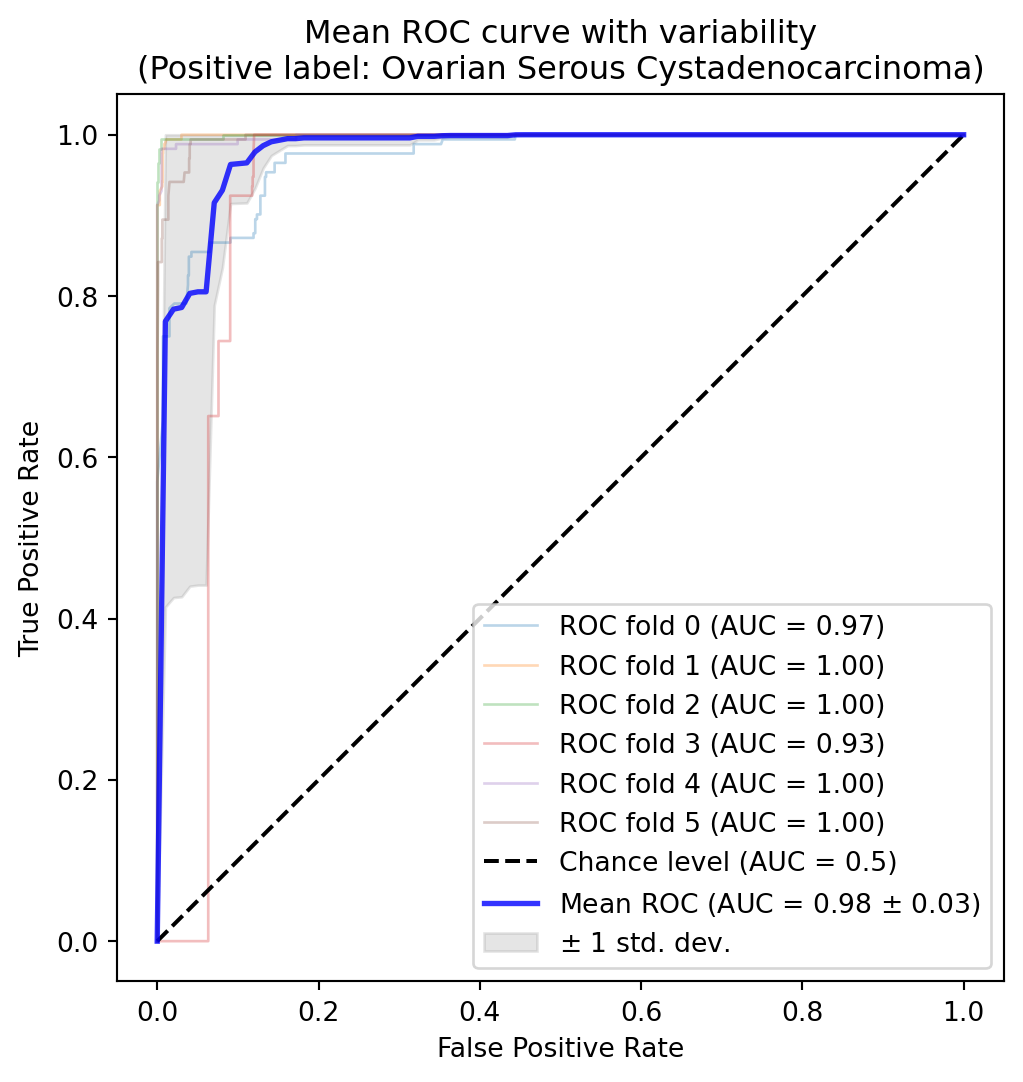

In [6]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X[test],
        y[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == nsplits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Mean ROC curve with variability\n(Positive label: Ovarian Serous Cystadenocarcinoma)",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()

## Conclusion

Cancer is now solved, metadata for the cure.